In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmaps
import pandas as pd
import subprocess
import bct
%matplotlib inline

# Auxiliar code
Graph format, paths, and other global definitions

In [23]:
SAVEPATH = "graphs/"

# Phase diagram 
To play with the phase diagram of different cases

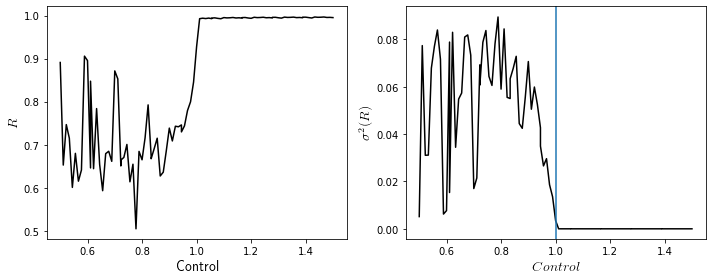

In [3]:
path = "./../data/pd-het/"
name = "rb7-snic"

nparts = 9

data = np.empty((0,3))
for part in range(nparts):
    datafile = np.loadtxt(path + name + "_part{0}".format(part))
    data = np.append(data, datafile, axis=0)
del datafile

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].plot(data[:,0], data[:,1], color="black")#, marker="o", ls=":")
axes[1].plot(data[:,0], data[:,2], color="black")#, marker="o", ls=":")

axes[0].set_xlabel(r'Control', fontsize=14, usetex=True)
axes[0].set_ylabel(r'$R$', fontsize=14, usetex=True)

axes[1].set_ylabel(r'$\sigma^2(R)$', fontsize=14, usetex=True)
axes[1].set_xlabel(r'$Control$', fontsize=14, usetex=True)
axes[1].axvline(1)
plt.tight_layout()

#plt.savefig(SAVEPATH + name + "_pd.pdf")
plt.show()

Produce a well-ordered table of phase diagrams, depending on different cases

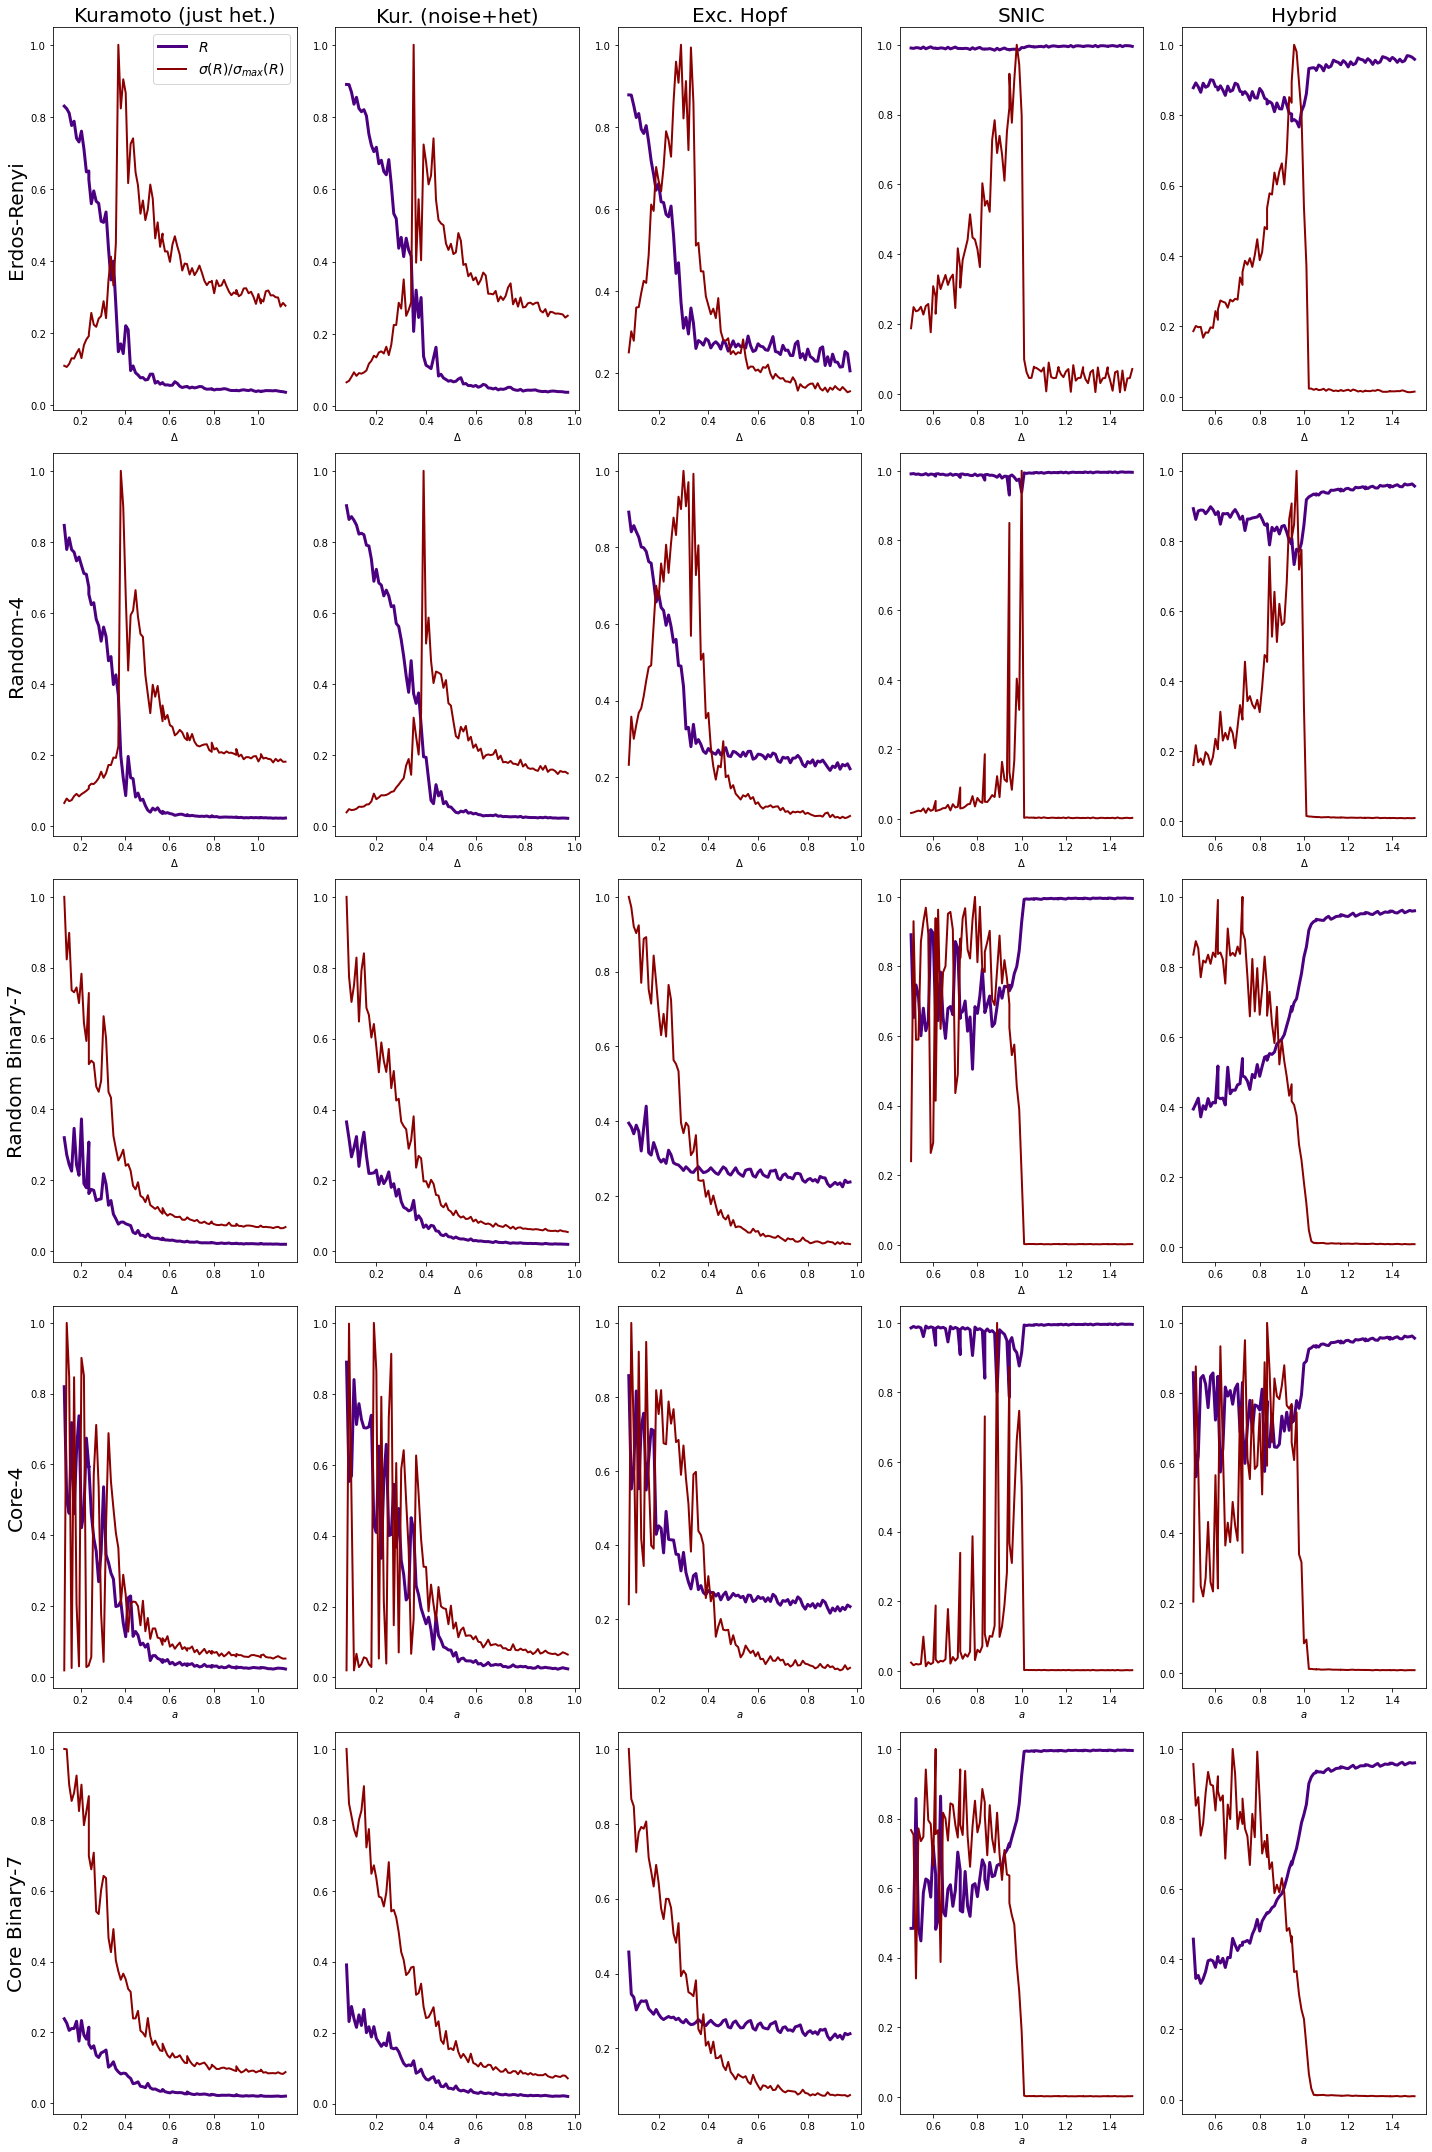

In [5]:
path = "./../data/pd-het/"
nparts = 9

networks = ["erdos-renyi", "r4", "rb7", "c4", "cb7"]
netsize  = [1000, 3000, 3840, 3000, 3840]
dynamics = ["kuramoto", "-non-excitable", "-exc_hopf", "-snic", "-hybrid"]
dyncontrol = [r"$\Delta$", r"$\Delta$", r"$\Delta$", r"$a$", r"$a$"]


rownames = ["Erdos-Renyi", "Random-4", "Random Binary-7", "Core-4", "Core Binary-7"]
colnames = ["Kuramoto (just het.)", "Kur. (noise+het)", "Exc. Hopf", "SNIC", "Hybrid"]
fig, axes = plt.subplots(figsize=(20,30), ncols=len(networks), nrows=len(dynamics))

for i,net in enumerate(networks):
    for j,dyn in enumerate(dynamics):
        name = net + dyn
        data = np.empty((0,3))
        for part in range(nparts):
            datafile = np.loadtxt(path + name + "_part{0}".format(part))
            data = np.append(data, datafile, axis=0)
        del datafile

        axes[i,j].plot(data[:,0], data[:,1], color="indigo", lw=3, label="$R$")
        variance = np.sqrt(data[:,2])
        axes[i,j].plot(data[:,0], variance / np.max(variance), color="darkred", lw=2, label=r"$\sigma(R) / \sigma_{max}(R)$")
        axes[i,j].set_xlabel(dyncontrol[i])
        
axes[0,0].legend(loc="upper right", fontsize=14)
for ax, col in zip(axes[0], colnames):
    ax.set_title(col, fontsize=20)

for ax, row in zip(axes[:,0], rownames):
    ax.set_ylabel(row, fontsize=20)

fig.tight_layout()
plt.savefig(SAVEPATH+"phase_diagrams.pdf")
plt.show()

# Time trace analysis
This one takes the phases of all oscillators, and, knowing the structure of the network, gets the synchronization dynamics of all hierarchical layers

In [6]:
def kuramoto(phases):
    return np.mean(np.exp(1.0j * phases), axis=1)

def time_trace_analysis(filename, n_com, layer, dt=0.01, max_plots=30, savefig=None):
    """
    n_com: array that says how much communities are inside a given one
    layer: which hierarchical layer we want to get. Starts at 1
    dt: to set the correct temporal scale of the X axis, timestep used in simulation
    max_plots: maximum number of lines to show at once
    """
    
    n_levels = np.size(n_com)

    if layer!="all" and (layer < 0 or layer > n_levels):
        print("Layer has to be between 1 and the number of layers, or to be 'all'")
        return
        
    #Load data and get its size
    phases = np.loadtxt(filename)
    
    n = np.size(phases[0,:])
    tsteps = np.size(phases[:,0])
    
    #Generate X axis
    t = np.linspace(0, tsteps * dt, tsteps)
    
    if layer=="all":
        for layer in range(1,n_levels+1):
            #Number of neurons in each group
            n_layer = np.prod(n_com[:layer])
            n_groups = n // n_layer

            #Colors
            n_plots = min(max_plots, n_groups)
            cmap = cmaps.get_cmap('cividis')    

            plt.figure()
            for j in range(n_plots):
                z = kuramoto(phases[:,j*n_layer:(j+1)*n_layer])
                plt.plot(t, np.abs(z), color = cmap(j/n_plots))
            plt.xlabel("$t$")
            plt.ylabel("$R$")
            plt.tight_layout()
            if savefig != None:
                plt.savefig(SAVEPATH+"timetrace/{name}_layer{l}.pdf".format(name=savefig, l=layer), bbox_inches="tight")
                plt.close()
            else:
                plt.show()
    else:
        #Number of neurons in each group
        n_layer = np.prod(n_com[:layer])
        n_groups = n // n_layer

        #Colors
        n_plots = min(max_plots, n_groups)
        
        cmap = cmaps.get_cmap('seismic')    

        plt.figure()
        for j in range(n_plots):
            z = kuramoto(phases[:,j*n_layer:(j+1)*n_layer])
            plt.plot(t, np.abs(z), color = cmap(j/n_plots))
            print(cmap(j/n_plots))
        plt.xlabel("$t$")
        plt.ylabel("$R$")
        plt.tight_layout()
        if savefig != None:
            plt.savefig(SAVEPATH+"timetrace/"+savefig, bbox_inches="tight")
            plt.close()
        else:
            plt.show()
    

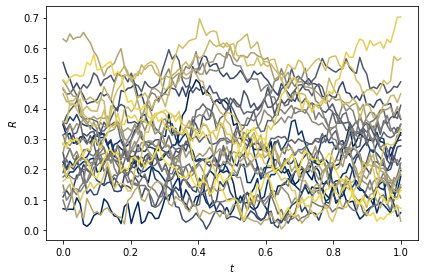

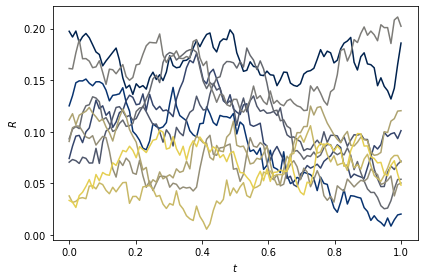

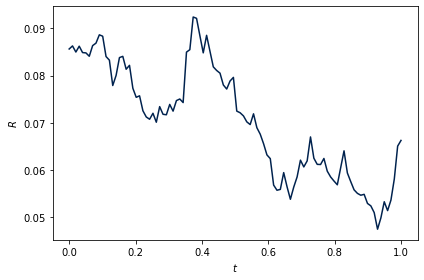

In [58]:
#n_layer = [100,5,3,2]
n_layer = [10,10,10]

time_trace_analysis("../data/timetrace/erdos-renyihopf_super_trace0", n_layer, "all")

In [459]:
network_structure = {"erdos-renyi":[10,10,10], "r4": [100,5,3,2], "c4": [100,5,3,2], "rb7": [30,2,2,2,2,2,2,2], "cb7":[30,2,2,2,2,2,2,2]}

a_list = [0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.9, 1.1, 1.07, 0.9, 1.1, 1.0]
s_list = [0.8, 1.0, 1.2, 0.8, 0.9, 1.0, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1]
name_list = ["hopf_sub", "hopf_crit", "hopf_super", "hopf_exc_sub", "hopf_exc_crit", "hopf_exc_super", "hyb_sub", "hyb_crit", "hyb_super", "snic_sub", "snic_crit", "snic_super"]

for network in network_structure:
    print(network)
    n_layer = network_structure[network]
    for a,s,name in zip(a_list, s_list, name_list):
        time_trace_analysis("../data/timetrace/" + network + name + "_trace0", n_layer, "all", savefig=network + name)

erdos-renyi
r4
c4
rb7
cb7


## Correlations and Functional connectivity

Implementation of functional connectivity measures, trying to get functional connectivity matrices

In [98]:
def functional_structure(filename, n_com, ntraces=1, dt=0.01, ordered=True, activity_function=lambda z: 0.5*np.abs(z)*(1+np.sin(np.angle(z))), compute_deviation=False):
    """
    filename: where the data is stored
    n_com: array that says how much communities are inside a given one
    ntracies: number of time traces recorded
    dt: to set the correct temporal scale of the X axis, timestep used in simulation
    ordered: if True, performs a communnity detection algorithm, sorting the displayed matrix accordingly
    """
    
    n_levels = np.size(n_com)

    #Load data and get its properties
    phases = np.loadtxt(filename + "_trace0")
    
    n_base = n_com[0]
    n = np.size(phases[0,:])
    n_modules = n // n_base
    tsteps = np.size(phases[:,0])
    
    corrmatrix = np.zeros((n_modules, n_modules))
    
    for trace in range(ntraces):
        if trace > 0:
            phases = np.loadtxt(filename + "_trace" + str(trace))
        
        z = np.empty((n_modules, tsteps), dtype=complex)
        for j in range(n_modules):
            z[j,:] = kuramoto(phases[:, n_base*j : n_base*(j+1)])
        del phases

        activity = activity_function(z)
        #corrmatrix += np.abs(np.corrcoef(activity)) 
        corrmatrix += np.corrcoef(activity)
        #corrmatrix[corrmatrix < 0.3] = 0.0 
        
    corrmatrix /= ntraces
    
    if compute_deviation:
        avcorr = np.mean(corrmatrix)
        corrmatrix = (corrmatrix - avcorr) * (corrmatrix - avcorr)    
    
    ci,q = bct.modularity_louvain_und_sign(corrmatrix)
    ci,q = bct.modularity_probtune_und_sign(corrmatrix, ci=ci)    
    bound, indsort = bct.grid_communities(ci)
    
    return corrmatrix, indsort

def draw_single_funcstruct(filename, n_com, ntraces=1, dt=0.01, ordered=True, activity_function=lambda z: 0.5*np.abs(z)*(1+np.sin(np.angle(z))), compute_deviation=False, savefig=None):
    """
    filename: where the data is stored
    n_com: array that says how much communities are inside a given one
    layer: which hierarchical layer we want to get. Starts at 1
    dt: to set the correct temporal scale of the X axis, timestep used in simulation
    max_plots: maximum number of lines to show at once
    """
    
    outputpath = "functional/"
    if compute_deviation:
        outputpath += "variability/"
        
    corrmatrix, indsort = functional_structure(filename, n_com, ntraces, dt, ordered, activity_function, compute_deviation)
    
    if compute_deviation:
        imbounds = [0,4]
        cmap = plt.cm.get_cmap("Reds")
    else:
        imbounds = [0,1]
        cmap = plt.cm.get_cmap("viridis")
    

    plt.figure()
    if ordered:
        plt.imshow(corrmatrix[np.ix_(indsort, indsort)], cmap=cmap, interpolation="None", vmin=imbounds[0], vmax=imbounds[1])
    else:
        plt.imshow(corrmatrix, cmap=cmap, interpolation="None", vmin=imbounds[0], vmax=imbounds[1])

    plt.tight_layout()
    if savefig ==None:
        plt.show()
    else:
        plt.savefig(SAVEPATH + outputpath + savefig + '-matrix.pdf', bbox_inches="tight")
        plt.close()

    
def draw_functional_table(filename, n_com, ntraces=1, dt=0.01, ordered=True, activity_function=lambda z: 0.5*np.abs(z)*(1+np.sin(np.angle(z))), compute_deviation=False, savefig=None):
    """
    filename: where the data is stored
    n_com: array that says how much communities are inside a given one
    layer: which hierarchical layer we want to get. Starts at 1
    dt: to set the correct temporal scale of the X axis, timestep used in simulation
    max_plots: maximum number of lines to show at once
    """
    
    initial_filename = filename
    
    outputpath = ""
    if compute_deviation:
        outputpath += "variability/"
    
    dynlist = ["hopf", "hopf_exc", "snic", "hyb"]
    cases = ["sub", "crit", "super"]
    
    colnames = ["Subcritical", "Critical", "Supercritical"]
    rownames = ["Kuramoto (noise + het.)", "Excitable Hopf", "SNIC", "Hybrid"] 
    
    fig, axes = plt.subplots(ncols=3, nrows = len(dynlist), figsize=(10,15)) #plt.figure()
    for i,dynamics in enumerate(dynlist):
        for j,case in enumerate(cases):
            filename = initial_filename + dynamics + "_" + case
            corrmatrix, indsort = functional_structure(filename, n_com, ntraces, dt, ordered, activity_function, compute_deviation)

            if compute_deviation:
                imbounds = [0,4]
                cmap = plt.cm.get_cmap("Reds")
            else:
                imbounds = [-1,1]
                cmap = plt.cm.get_cmap("BrBG")
    
    
            if ordered:
                axes[i,j].imshow(corrmatrix[np.ix_(indsort, indsort)], cmap=cmap, interpolation="None", vmin=imbounds[0], vmax=imbounds[1])
            else:
                axes[i,j].imshow(corrmatrix, cmap=cmap, interpolation="None", vmin=imbounds[0], vmax=imbounds[1])

    for ax, col in zip(axes[0], colnames):
        ax.set_title(col, fontsize=20)

    for ax, row in zip(axes[:,0], rownames):
        ax.set_ylabel(row, fontsize=20)
    
    plt.tight_layout()
    if savefig ==None:
        plt.show()
    else:
        plt.savefig(SAVEPATH + outputpath + savefig + '-functable.pdf', bbox_inches="tight")
        plt.close()

erdos-renyi


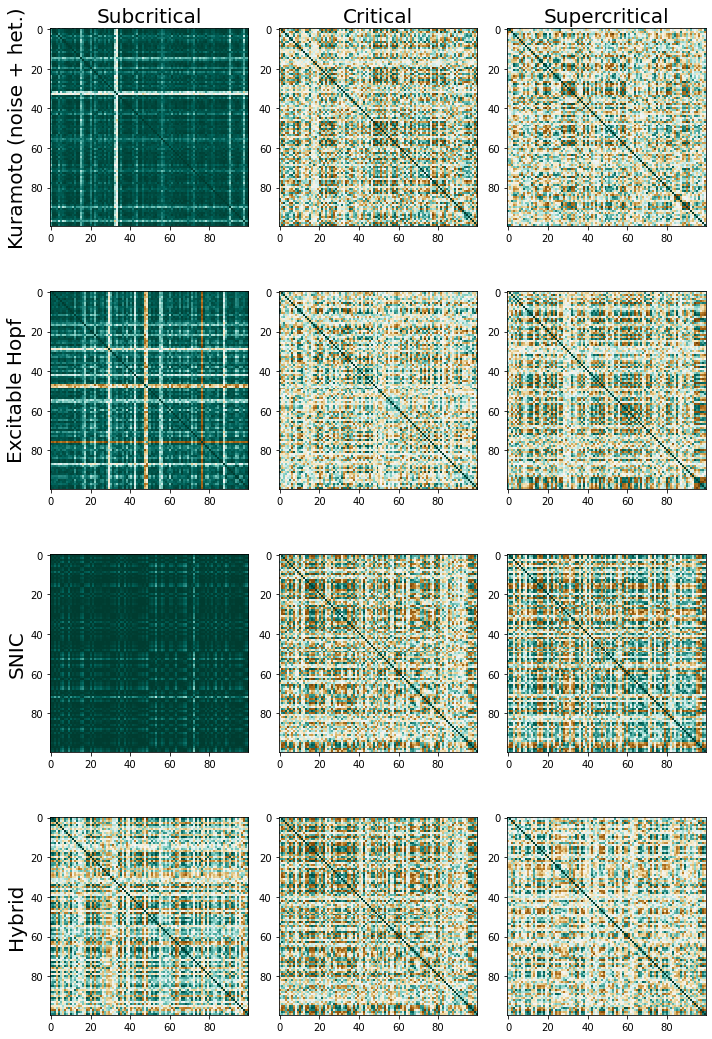

r4


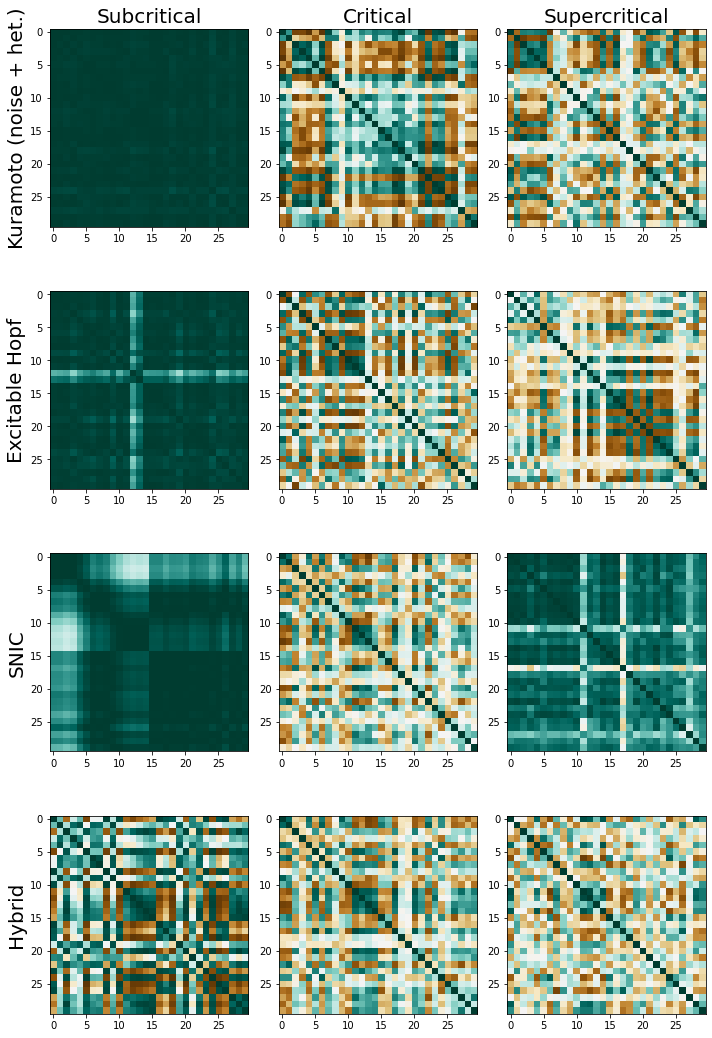

c4


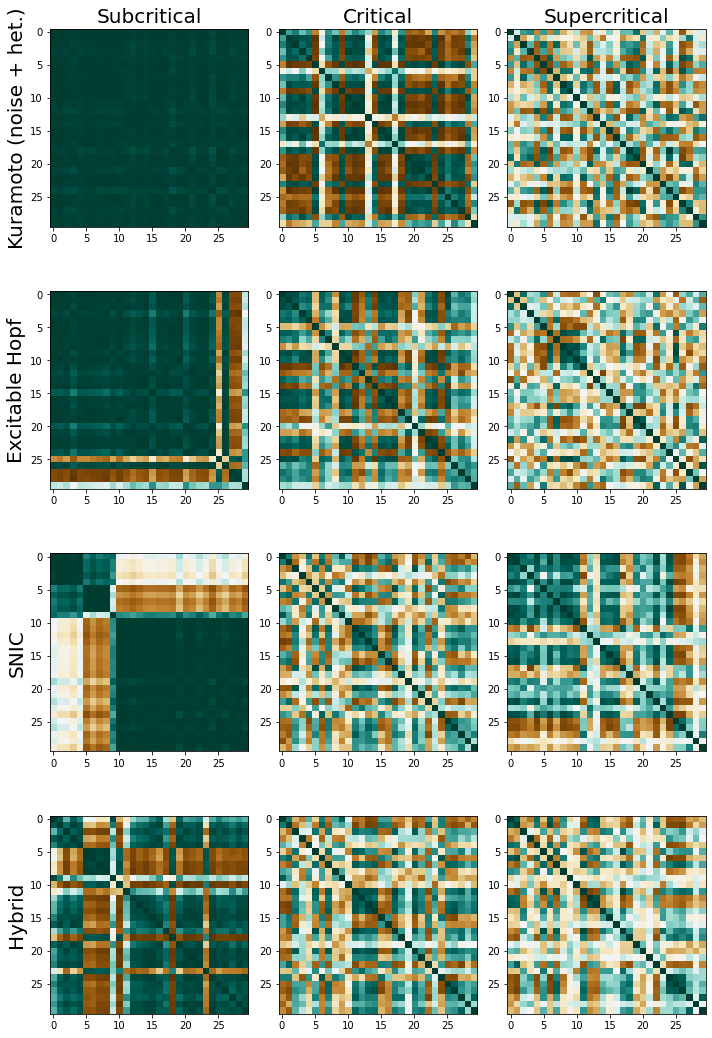

rb7


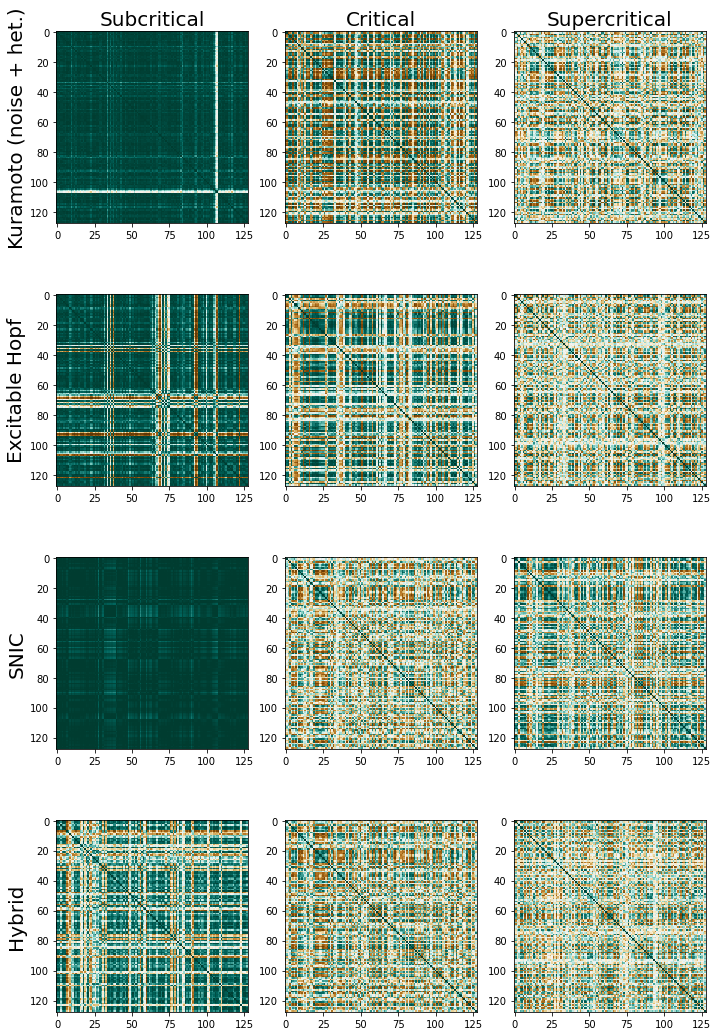

cb7


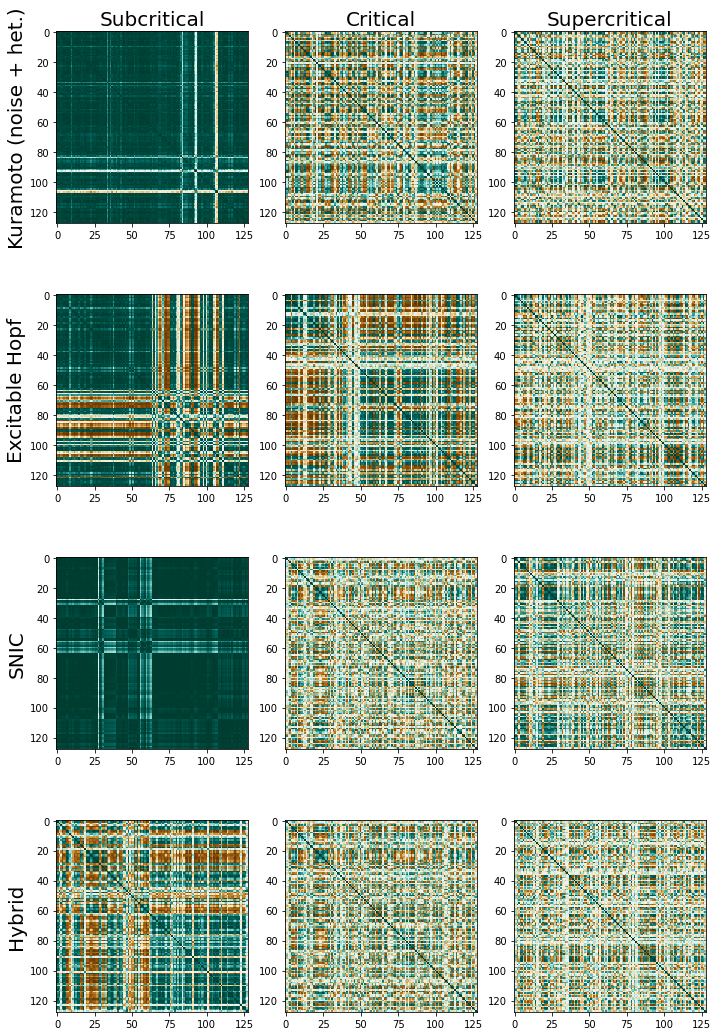

In [103]:
network_structure = {"erdos-renyi":[10,10,10], "r4": [100,5,3,2], "c4": [100,5,3,2], "rb7": [30,2,2,2,2,2,2,2], "cb7":[30,2,2,2,2,2,2,2]}
savefig = False
for network in network_structure:
    n_layer = network_structure[network]
    print(network)
    if savefig:
        draw_functional_table("../data/timetrace/" + network, n_layer, ntraces=1, compute_deviation=do_deviation, savefig=network+"_rpm_unordered")
    else:
        draw_functional_table("../data/timetrace/" + network, n_layer, ntraces=1, compute_deviation=do_deviation, ordered=False)